In [25]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install xgboost
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import train_test_split

import shap
import xgboost as xgb

shap.initjs()

In [99]:
csv_path = "sc_predict_dataset.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)
df["circuit_id_code"], _ = pd.factorize(df["circuit_id"])

df.head()

,race_id,year,circuit_id,is_street_circuit,lap_number,total_laps,status_sc_active,status_vsc_active,num_cars_running,min_gap_between_any_cars,...,num_pitstops_last_1_lap,avg_tyre_age_laps,air_temperature,humidity,pressure,rainfall,track_temperature,wind_speed,label_sc_next_lap,circuit_id_code
0,2023_SAKHIR_R,2023,SAKHIR,0,1,57,0,0,20,0.000,...,0,2.35,26.2,21,1017.5,0,28.7,0.3,0,0
1,2023_SAKHIR_R,2023,SAKHIR,0,2,57,0,0,20,0.007,...,0,3.35,27.3,22,1016.9,0,31.1,0.6,0,0
2,2023_SAKHIR_R,2023,SAKHIR,0,3,57,0,0,20,0.047,...,0,4.35,27.3,22,1016.7,0,31.2,0.6,0,0
3,2023_SAKHIR_R,2023,SAKHIR,0,4,57,0,0,20,0.041,...,0,5.35,27.2,22,1016.9,0,31.1,0.8,0,0
4,2023_SAKHIR_R,2023,SAKHIR,0,5,57,0,0,20,0.048,...,0,6.35,27.2,22,1016.9,0,31.0,0.6,0,0


In [100]:
target_col = "label_sc_next_lap"
drop_cols = ["race_id", "circuit_id", "year", "total_laps", "lap_number", target_col]

feature_cols = [c for c in df.columns if c not in drop_cols]

# --- New: random split by race_id, not by year ---

from sklearn.model_selection import train_test_split

# Unique race identifiers
unique_races = df["race_id"].unique()

# First split: train vs (val+test)
train_races, valtest_races = train_test_split(
    unique_races,
    test_size=0.4,        # 60% train, 40% reserved for val+test
    random_state=42,
)

# Second split: val vs test from the remaining races
val_races, test_races = train_test_split(
    valtest_races,
    test_size=0.5,        # 20% val, 20% test overall
    random_state=42,
)

# Build the three dataframes
df_train = df[df["race_id"].isin(train_races)].reset_index(drop=True)
df_val   = df[df["race_id"].isin(val_races)].reset_index(drop=True)
df_test  = df[df["race_id"].isin(test_races)].reset_index(drop=True)

X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

X_val = df_val[feature_cols].values
y_val = df_val[target_col].values

X_test = df_test[feature_cols].values
y_test = df_test[target_col].values

print("Feature columns:")
print(feature_cols)
print()
print("Num races - train:", len(train_races),
      "| val:", len(val_races),
      "| test:", len(test_races))
print("Row counts  - train:", X_train.shape[0],
      "| val:", X_val.shape[0],
      "| test:", X_test.shape[0])


Feature columns:
['is_street_circuit', 'status_sc_active', 'status_vsc_active', 'num_cars_running', 'min_gap_between_any_cars', 'num_pairs_gap_lt_1s', 'num_pitstops_last_1_lap', 'avg_tyre_age_laps', 'air_temperature', 'humidity', 'pressure', 'rainfall', 'track_temperature', 'wind_speed', 'circuit_id_code']

Num races - train: 52 | val: 17 | test: 18
Row counts  - train: 2706 | val: 866 | test: 954


In [101]:
def compute_scale_pos_weight(y):
    n_pos = (y == 1).sum()
    n_neg = (y == 0).sum()
    if n_pos == 0:
        return 1.0
    return float(n_neg) / float(n_pos)

scale_pos_weight = compute_scale_pos_weight(y_train)

print("Positive rate in train:", y_train.mean())
print("scale_pos_weight (neg / pos):", scale_pos_weight)


Positive rate in train: 0.1614929785661493
scale_pos_weight (neg / pos): 5.192219679633867


In [102]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",  # PR AUC is good for imbalance
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "min_child_weight": 5,
    "lambda": 1.0,
    "alpha": 0.0,
    "scale_pos_weight": scale_pos_weight,
    "nthread": 4,
}

evals = [(dtrain, "train"), (dval, "val")]

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=25,
)

booster


[0]	train-aucpr:0.77974	val-aucpr:0.11799
[25]	train-aucpr:0.94274	val-aucpr:0.13071
[41]	train-aucpr:0.97318	val-aucpr:0.11867


In [103]:
def evaluate_model(model, X, y, split_name: str):
    d = xgb.DMatrix(X)
    y_pred_prob = model.predict(d)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    print(f"\n=== {split_name} metrics ===")
    print("Positive rate:", float(y.mean()))
    print("Predicted positive rate:", float(y_pred.mean()))

    print("\nConfusion matrix (rows = true, cols = pred):")
    print(confusion_matrix(y, y_pred))

    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=3))

    try:
        roc = roc_auc_score(y, y_pred_prob)
    except ValueError:
        roc = float("nan")
    pr_auc = average_precision_score(y, y_pred_prob)

    print(f"ROC AUC: {roc:.4f}")
    print(f"PR AUC:  {pr_auc:.4f}")

In [91]:
evaluate_model(booster, X_train, y_train, split_name="Train")
evaluate_model(booster, X_val, y_val, split_name="Validation")
evaluate_model(booster, X_test, y_test, split_name="Test")


=== Train metrics ===
Positive rate: 0.1614929785661493
Predicted positive rate: 0.20546932742054694

Confusion matrix (rows = true, cols = pred):
[[2142  127]
 [   8  429]]

Classification report:
              precision    recall  f1-score   support

           0      0.996     0.944     0.969      2269
           1      0.772     0.982     0.864       437

    accuracy                          0.950      2706
   macro avg      0.884     0.963     0.917      2706
weighted avg      0.960     0.950     0.952      2706

ROC AUC: 0.9945
PR AUC:  0.9746

=== Validation metrics ===
Positive rate: 0.11431870669745958
Predicted positive rate: 0.03233256351039261

Confusion matrix (rows = true, cols = pred):
[[743  24]
 [ 95   4]]

Classification report:
              precision    recall  f1-score   support

           0      0.887     0.969     0.926       767
           1      0.143     0.040     0.063        99

    accuracy                          0.863       866
   macro avg      0.515

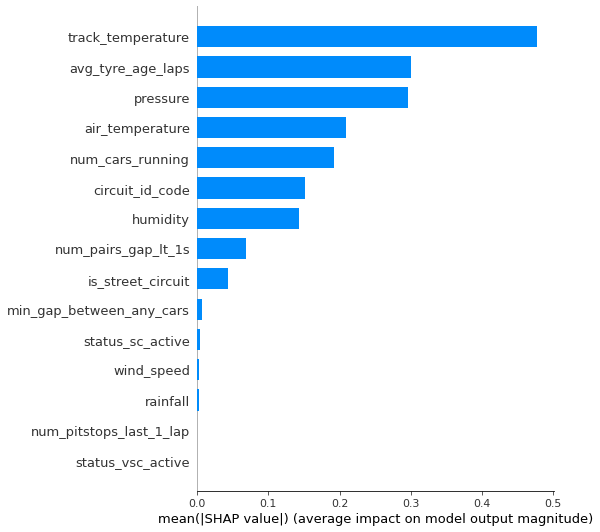

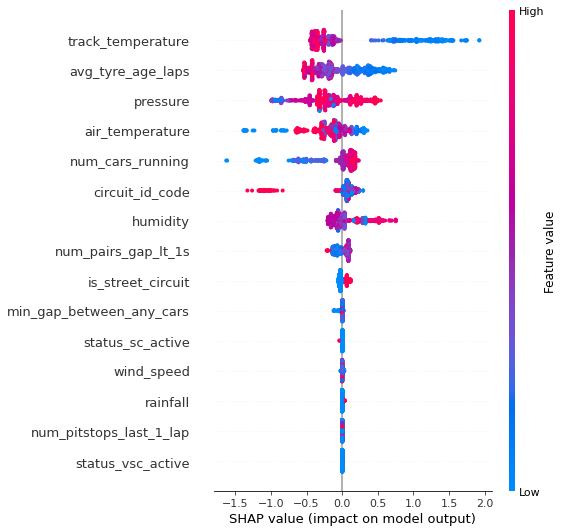

In [104]:
# Use a subset of the training data as background
background_size = min(1000, X_train.shape[0])
X_background = X_train[:background_size]

explainer = shap.TreeExplainer(booster, data=X_background)

test_sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test[:test_sample_size]

shap_values_test = explainer.shap_values(X_test_sample)

shap.summary_plot(
    shap_values_test,
    X_test_sample,
    feature_names=feature_cols,
    plot_type="bar"
)

shap.summary_plot(
    shap_values_test,
    X_test_sample,
    feature_names=feature_cols
)

In [ ]:
model_out = "xgb_sc_next_lap.json"
booster.save_model(model_out)
print("Saved model to:", model_out)

feat_path = "xgb_sc_next_lap_features.txt"
with open(feat_path, "w") as f:
    for c in feature_cols:
        f.write(c + "\n")
print("Saved feature list to:", feat_path)


In [67]:
df["rainfall"].value_counts()


0    4361
1     165
Name: rainfall, dtype: int64